In [139]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import copy
%matplotlib inline
plt.rcParams['figure.figsize']=(3, 3)
plt.rcParams['image.interpolation']= 'nearest'
plt.rcParams['image.cmap']= 'gray'
np.random.seed(1)

#### LOADING THE DATA

In [23]:
def load_data():
    train_dataset=h5py.File('scratch_implementation_data/train_catvnoncat.h5', 'r')

    train_set_x_orig=np.array(train_dataset["train_set_x"][:])
    train_set_y_orig=np.array(train_dataset["train_set_y"][:])

    test_dataset=h5py.File('scratch_implementation_data/test_catvnoncat.h5', 'r')
    test_set_x_orig=np.array(test_dataset['test_set_x'][:])
    test_set_y_orig=np.array(test_dataset['test_set_y'][:])
    
    classes=np.array(test_dataset["list_classes"][:])
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [24]:
train_x_orig, train_y, test_x_orig, test_y, classes= load_data()
#the shape of different data arrays are:
print("Train x: " + str(train_x_orig.shape) + "\nTrain y: " + str(train_y.shape))
print("Test x: " + str(test_x_orig.shape) + "\nTest y: " + str(test_y.shape))

Train x: (209, 64, 64, 3)
Train y: (209,)
Test x: (50, 64, 64, 3)
Test y: (50,)


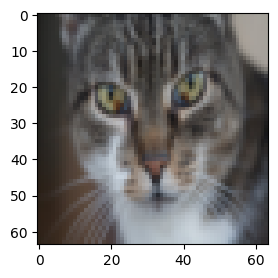

y = 1
This is a cat image


In [25]:
#viewing an image from the training set
#you can change the value of index to view different images
index=56
plt.imshow(train_x_orig[index])
plt.show()
print("y = "+str(train_y[index]))
print("This is a", 'cat' if train_y[index]==1 else 'non-cat', "image")

### DATA PREPROCESSING

In [26]:
#reshape train_x, test_x to (64*64*3, 209)
train_x=train_x_orig.reshape(train_x_orig.shape[0], -1).T  
test_x=test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x=train_x.astype(np.float32)
test_x=test_x.astype(np.float32)
#scaling of pixel values
train_x/=255
test_x/=255.

print("train_x shape: ", train_x.shape)
print("test_x shape: ", test_x.shape)

train_x shape:  (12288, 209)
test_x shape:  (12288, 50)


In [29]:
train_y = train_y.reshape(1, 209)
test_y = test_y.reshape(1, 50)

### HELPER FUNCTIONS

In [7]:
def sigmoid(z):
    A = 1/(1+np.exp(-z))
    cache = z  #storing the value of z for use in backward propagation
    return A, cache

def relu(z):
    A = np.maximum(0, z)
    cache = z
    return A, cache

def sigmoid_backward(dA, cache):
    z = cache
    s = 1/(1+np.exp(-z))
    return dA*s*(1-s)  #chain rule of differentiation

def relu_backward(dA, cache):
    '''
    Argument:
        dA -- the backward value of activation
        cache -- the  
    '''
    z = cache
    dZ = np.array(dA, copy=True)
    dZ[z<=0] = 0
    return dZ

In [38]:
def initialize_parameters(layer_dims):
    """
    Arguments: 
        layer_dims -- python dictionary containing the dimensions of each layer in our network

    Returns: 
        parameters -- python dictionary containing parameters "W1", "b1"..."WL, "bL"
        """
    np.random.seed(1)
    parameters={}

    L=len(layer_dims)
    for l in range(1, L):
        parameters["W" + str(l)]= np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters["b" + str(l)]=np.zeros((layer_dims[l], 1))
        
    return parameters

In [19]:
par_temp = initialize_parameters([12, 24, 48, 96, 10, 1])

In [20]:
len(par_temp)

10

In [21]:
x_temp = np.random.randn(12, 50)

In [22]:
al_temp, caches_temp = L_model_forward(x_temp, par_temp)

In [23]:
al_temp.shape

(1, 50)

### FORWARD PROPAGATION

In [9]:
def linear_forward(A, W, b):
    Z=np.dot(W, A) + b
    cache= (A, W, b)
    return Z, cache

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)   

    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache= (linear_cache, activation_cache)
    return A, cache

In [11]:
#function to implement for all layers
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters)//2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

### COMPUTE COST

In [41]:
def compute_cost(AL, Y):
    '''
    Arguments:
        AL -- value of final activations
        Y -- true value of activations
    Returns: 
        cost -- the squeezed value of cost'''
    m=Y.shape[1]
    
    #log loss function
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost=np.squeeze(cost) #to reduce extra array dimensions
    return cost

### BACKWARD PROPAGATION

In [42]:
#calculate dA_prev, dW, db from dZ
def linear_backward(dZ, linear_cache):
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dA_prev = np.dot(W.T, dZ)
    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True)

    return dA_prev, dW, db

In [43]:
#calculate dA_prev, dW, db from dA
def linear_activation_backward(dA, cache, activation):
    '''
    Arguments:
        dA -- Derivate of output of a layer
        cache -- values of cache used for each layer in foward propagation
        activation -- the activation function used in layer
        
    Returns:
        dA_prev -- gradient of activations for previous layer
        dW, db -- update parameters
    '''
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    else:
        print("Error in function linear_activation_backward")

    return dA_prev, dW, db

In [44]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    #initialize the backpropagation
    dAL= -np.divide(Y, AL) + np.divide(1-Y, 1-AL)
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, caches[L-1], 'sigmoid')
    grads["dA"+str(L-1)] = dA_prev_temp
    grads["dW"+str(L)] = dW_temp
    grads["db"+str(L)] = db_temp

    #loop from L-2 to 0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache, 'relu')
        grads['dA'+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)] = db_temp

    return grads

In [45]:
def update_parameters(parameters, grads, learning_rate):
    parameters = copy.deepcopy(parameters)
    L=len(parameters)//2

    for l in range(L):
        parameters["W"+str(l+1)] -= (learning_rate * grads["dW" + str(l+1)])
        parameters["b"+str(l+1)] -= (learning_rate * grads["db" + str(l+1)])

    return parameters

In [95]:
def predict(X, parameters):
    m = X.shape[1]
    n = len(parameters)//2
    p = np.zeros((1, m))
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
            
    return p

In [125]:
def train(train_x, train_y, layer_dims, num_iterations=600, learning_rate=0.0075):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters(layer_dims)

    for i in range(num_iterations+1):
         AL, caches = L_model_forward(train_x, parameters)
         cost = compute_cost(AL, train_y)
         grads = L_model_backward(AL, train_y, caches)
         parameters = update_parameters(parameters, grads, learning_rate)

         if i%100==0:
            print(f"Cost at iteration {i} is: {cost:.8f}")
            costs.append(cost)
    return parameters, costs

In [126]:
layer_dims = [12288, 512, 128, 32, 8, 1]
parameters, costs = train(train_x, train_y, layer_dims)

Cost at iteration 0 is: 0.70318526
Cost at iteration 100 is: 0.58052855
Cost at iteration 200 is: 0.49688433
Cost at iteration 300 is: 0.42251451
Cost at iteration 400 is: 0.34760884
Cost at iteration 500 is: 0.26981388
Cost at iteration 600 is: 0.16450637


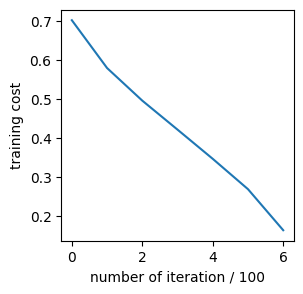

In [138]:
plt.plot(np.arange(0, len(costs)), np.array(costs))
plt.xlabel("number of iteration / 100")
plt.ylabel("training cost")
plt.show()

In [103]:
#Test Set Accuracy
prediction_test = predict(test_x, parameters) 
print("Test set accuracy: " + str(np.sum(prediction_test == test_y)/test_y.shape[1]))

Test set accuracy: 0.8


In [104]:
#Training Set Accruacy
prediction_train = predict(train_x, parameters)  
print("Train set accuracy: " + str(np.sum(prediction_train == train_y)/train_y.shape[1]))

Train set accuracy: 0.9617224880382775


In [118]:
#Test the network on custom image
from PIL import Image
image_path = input("Enter image path: ")
with Image.open(image_path) as img:
    scaled_img = img.resize((64, 64))
img.close()

inp_array = np.array(scaled_img.getdata()).reshape(64*64*3, 1) / 255.0
print("This is cat image" if predict(inp_array, parameters) == 1 else "This is not-cat image")

Enter image path:  car1.jpeg


This is not-cat image
